<a href="https://colab.research.google.com/github/NikitaMarshchonok/iot-anomaly-pipeline/blob/main/notebooks/train_lstm_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ⌗ 1  Чистим конфликтующие пакеты
!pip uninstall -y -q keras keras-core tensorflow tensorflow-cpu tensorflow-gpu tensorflow-intel

# ⌗ 2  Ставим согласованный стек
!pip install -q tensorflow==2.18.0 ml-dtypes==0.3.1 pandas scikit-learn matplotlib

# ⌗ 3  Проверяем
import tensorflow as tf, sys
print("TF:", tf.__version__, "GPU:", tf.config.list_physical_devices('GPU'))



ERROR: Cannot install ml-dtypes==0.3.1 and tensorflow==2.18.0 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
TF: 2.18.0 GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# ⌗2  Генерируем 10 000 точек: синус + лёгкий шум, шаг 1 минута
import numpy as np, pandas as pd

np.random.seed(42)               # воспроизводимость
n_samples = 10_000

timestamps = pd.date_range("2024-01-01", periods=n_samples, freq="T")
pure_signal = np.sin(np.linspace(0, 50 * np.pi, n_samples))
noise = 0.1 * np.random.randn(n_samples)
series = pure_signal + noise

df = pd.DataFrame({"timestamp": timestamps, "value": series})
df.to_csv("sensor.csv", index=False)      # сохраняем — пригодится для локальных тестов
df.head()


/tmp/ipython-input-2-271389662.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range("2024-01-01", periods=n_samples, freq="T")


,timestamp,value
0,2024-01-01 00:00:00,0.049671
1,2024-01-01 00:01:00,0.001882
2,2024-01-01 00:02:00,0.096183
3,2024-01-01 00:03:00,0.199414
4,2024-01-01 00:04:00,0.039381


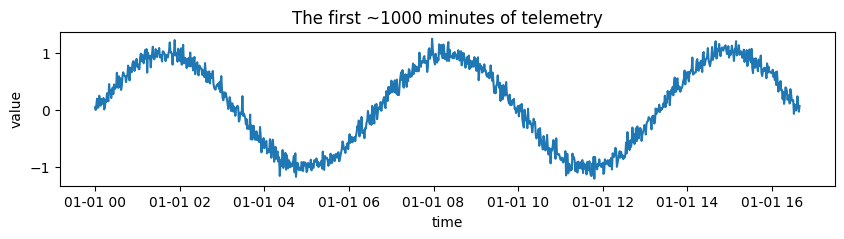

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,2))
plt.plot(df["timestamp"][:1000], df["value"][:1000])
plt.title("The first ~1000 minutes of telemetry")
plt.xlabel("time"); plt.ylabel("value"); plt.show()


In [5]:
# ⌗4  Масштабируем значения в [0,1] и режем на последовательности по 60 шагов (1 час)
from sklearn.preprocessing import MinMaxScaler

SEQ_LEN = 60                       # длина окна
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(df[["value"]])  # shape: (10000, 1)

def to_windows(array, window):
    """array shape (N, 1) → (N-window, window, 1)"""
    return np.array([array[i : i + window] for i in range(len(array) - window)])

X = to_windows(values_scaled, SEQ_LEN)
print("Windowed tensor shape:", X.shape)


Windowed tensor shape: (9940, 60, 1)


In [6]:
# ⌗5  Строим и компилируем модель
from tensorflow.keras import layers, Model, Input

inp = Input(shape=(SEQ_LEN, 1))

# --- Энкодер ---
x = layers.LSTM(64, return_sequences=True)(inp)   # скрытые состояния на каждом шаге
x = layers.LSTM(32)(x)                            # финальный латент-вектор (32)

# --- Декодер ---
x = layers.RepeatVector(SEQ_LEN)(x)               # «повторяем» латент window раз
x = layers.LSTM(32, return_sequences=True)(x)
out = layers.TimeDistributed(layers.Dense(1))(x)  # прогноз для каждого шага

model = Model(inp, out, name="lstm_autoencoder")
model.compile(optimizer="adam", loss="mse")
model.summary()


Model: "lstm_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,665 (147.13 KB)

 Trainable params: 37,665 (147.13 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ⌗6  Тренируем 10 эпох (Colab GPU: ~30 с)
history = model.fit(
    X, X,                    # вход = выход (реконструкция)
    epochs=10,
    batch_size=256,
    validation_split=0.1,
    verbose=1,
)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.1197 - val_loss: 0.0187
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0183 - val_loss: 0.0145
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0141 - val_loss: 0.0115
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0110 - val_loss: 0.0078
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0081 - val_loss: 0.0071
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0066 - val_loss: 0.0065


In [8]:
# ⌗7  Вычисляем reconstruction error на трейне
recon = model.predict(X, verbose=0)
errors = np.mean(np.square(X - recon), axis=(1,2))

# Порог: медиана + k * MAD
median = np.median(errors)
mad = np.median(np.abs(errors - median))
k = 6                                # empirically
THRESHOLD = median + k * mad
print(f"threshold = {THRESHOLD:.4e}")


threshold = 2.7529e-02


In [10]:
import tensorflow as tf
import joblib, json, zipfile, os, pathlib

EXPORT_DIR = "bundle"
MODEL_DIR  = f"{EXPORT_DIR}/saved_model"

# 0) создаём папку
os.makedirs(EXPORT_DIR, exist_ok=True)

# 1) SavedModel (tf.cluster format)
tf.saved_model.save(model, MODEL_DIR)

# 2) scaler.pkl
joblib.dump(scaler, f"{EXPORT_DIR}/scaler.pkl")

# 3) meta.json (порог, seq_len)
meta = {"threshold": float(THRESHOLD), "seq_len": SEQ_LEN}
with open(f"{EXPORT_DIR}/meta.json", "w") as f:
    json.dump(meta, f)

# 4) zip всё в один файл
zip_path = "lstm_ae_bundle.zip"
with zipfile.ZipFile(zip_path, "w") as z:
    for p in pathlib.Path(EXPORT_DIR).rglob("*"):
        z.write(p, p.relative_to(EXPORT_DIR))

print("📦 An archive has been compiled:", zip_path)


📦 Сформирован архив: lstm_ae_bundle.zip
